Import modules

In [1]:
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, std, dstack
from pandas import read_csv
from scipy.stats import chi2_contingency

#sklearn
from sklearn import set_config, metrics
from sklearn.model_selection import ShuffleSplit, GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, brier_score_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


#SKSURV
from sksurv.datasets import load_veterans_lung_cancer, load_gbsg2
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored, brier_score, cumulative_dynamic_auc
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

#TF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from keras.layers import Flatten, Dropout, Conv1D, MaxPooling1D
from keras.utils import to_categorical

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
import xgboost as xgb

from GPyOpt.methods import BayesianOptimization
from bayes_opt import BayesianOptimization
import shap

import argparse
import re
import io
import msoffcrypto
import warnings



%matplotlib inline


In [2]:
seed = 60
fpath = "/Users/robinlaheij/Downloads/L1992.2024-2.xlsx"

In [3]:

 
unlocked_file = io.BytesIO()

In [4]:

 
with open(fpath, "rb") as file:
    excel_file = msoffcrypto.OfficeFile(file)
    excel_file.load_key(password = "")
    excel_file.decrypt(unlocked_file)

In [5]:

df = pd.read_excel(unlocked_file, sheet_name='Data',
                    keep_default_na=False, na_values=''                
                   )
df_problemen = pd.read_excel(unlocked_file, sheet_name='Probleemlijst',
                    keep_default_na=False, na_values=''                
                   )
df2 = df.copy()


df2.shape


(8619, 20)

In [6]:
df.columns

Index(['Subtraject nummer', 'Patient_ID', 'Overleden datum',
       'Patiënt leeftijd', 'Roken', 'Alcoholgebruik', 'BMI', 'DBC specialisme',
       'DBC specialisme code', 'Diagnose', 'Diagnose code', 'Start datum',
       'Eind datum', 'Vorige zorgactiviteit datum', 'Zorgactiviteit datum',
       'Zorgactiviteit code', 'Zorgactiviteit', 'Medicatie',
       'Medicatie start datum', 'Medicatie eind datum'],
      dtype='object')

Change column names

In [7]:
df2 = df2.rename(columns={'Roken':"Smoking", 'Alcoholgebruik':'Alcohol', "Patiënt leeftijd": 'Age'})

In [8]:
columns_drop = ['Subtraject nummer', 'Patient_ID', 'Overleden datum','DBC specialisme',
       'DBC specialisme code', 'Diagnose', 'Diagnose code', 'Start datum',
       'Eind datum', 'Vorige zorgactiviteit datum', 'Zorgactiviteit datum',
       'Zorgactiviteit code', 'Zorgactiviteit',
       'Medicatie start datum', 'Medicatie eind datum']

columns_drop2 = ['Subtraject nummer', 'Patient_ID', 'Overleden datum','DBC specialisme',
       'DBC specialisme code', 'Diagnose', 'Diagnose code',
       'Eind datum', 'Vorige zorgactiviteit datum', 'Zorgactiviteit datum',
       'Zorgactiviteit code', 'Zorgactiviteit',
       'Medicatie start datum', 'Medicatie eind datum']

Re-arrange the df_prblemen into a joined df

In [9]:
# Define the mapping of ICD-10 code ranges to their classifications
icd_classifications = {
    'A00-B99': 'Certain infectious and parasitic diseases',
    'C00-C17': 'Neoplasms',
    'C18-C20': 'CRC',
    'C21-D49': 'Neoplasms',
    'D50-D89': 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
    'E00-E89': 'Endocrine, nutritional, and metabolic diseases',
    'F01-F99': 'Mental, Behavioral and Neurodevelopmental disorders',
    'G00-G99': 'Diseases of the nervous system',
    'H00-H59': 'Diseases of the eye and adnexa',
    'H60-H95': 'Diseases of the ear and mastoid process',
    'I00-I99': 'Diseases of the circulatory system',
    'J00-J99': 'Diseases of the respiratory system',
    'K00-K95': 'Diseases of the digestive system',
    'L00-L99': 'Diseases of the skin and subcutaneous tissue',
    'M00-M99': 'Diseases of the musculoskeletal system and connective tissue',
    'N00-N99': 'Diseases of the genitourinary system',
    'O00-O9A': 'Pregnancy, childbirth and the puerperium',
    'P00-P96': 'Certain conditions originating in the perinatal period',
    'Q00-Q99': 'Congenital malformations, deformations and chromosomal abnormalities',
    'R00-R99': 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
    'S00-T88': 'Injury, poisoning and certain other consequences of external causes',
    'V00-Y99': 'External causes of morbidity',
    'Z00-Z99': 'Factors influencing health status and contact with health services'
}

def classify_icd_code(icd_code):
    # handle sub cat by only chhecking first part before . 
    code = icd_code.split('.')[0]

    # Iterate through the classification ranges and find where the code fits
    for range_key, classification in icd_classifications.items():
        start, end = range_key.split('-')
        if start <= code <= end:
            return classification
    return 'Unknown classification'



In [10]:
df_prob = df_problemen[["Subtraject nummer", 'ICD10 code']]
df_prob['ICD10 code'] = df_prob['ICD10 code'].astype('str')
df_prob['ICD10'] = df_prob['ICD10 code'].apply(lambda x: classify_icd_code(str(x)))

In [11]:
df_prob = df_prob[["Subtraject nummer", 'ICD10']]

df_prob = df_prob.set_index('Subtraject nummer').rename(columns={'ICD10': ''})

In [12]:
dummy_df = pd.get_dummies(df_prob, prefix=None, prefix_sep='')
final_dummy_df = dummy_df.groupby(level=0).max().astype('int')


# Join the dummy variables with the original DataFrame
#df_with_dummies = df2.join(final_dummy_df)

In [13]:
df2 = df2.merge(final_dummy_df,on='Subtraject nummer')

In [141]:
final_dummy_df.columns

Index(['CRC', 'Certain infectious and parasitic diseases',
       'Congenital malformations, deformations and chromosomal abnormalities',
       'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
       'Diseases of the circulatory system',
       'Diseases of the digestive system',
       'Diseases of the ear and mastoid process',
       'Diseases of the eye and adnexa',
       'Diseases of the genitourinary system',
       'Diseases of the musculoskeletal system and connective tissue',
       'Diseases of the nervous system', 'Diseases of the respiratory system',
       'Diseases of the skin and subcutaneous tissue',
       'Endocrine, nutritional, and metabolic diseases',
       'External causes of morbidity',
       'Factors influencing health status and contact with health services',
       'Injury, poisoning and certain other consequences of external causes',
       'Mental, Behavioral and Neurodevelopmental disorders', 'Neoplas

In [14]:
df2['CRC'].value_counts()

CRC
0    8357
1      13
Name: count, dtype: int64

In [15]:
missing_percentage = df2.isna().mean() * 100
missing_percentage

Subtraject nummer                                                                                       0.000000
Patient_ID                                                                                              0.000000
Overleden datum                                                                                        96.344086
Age                                                                                                     0.000000
Smoking                                                                                                36.523297
Alcohol                                                                                                38.399044
BMI                                                                                                     3.906810
DBC specialisme                                                                                         0.000000
DBC specialisme code                                                                            

In [16]:
type_list = dict(df2.dtypes)


In [17]:
df2.isnull().sum()

Subtraject nummer                                                                                         0
Patient_ID                                                                                                0
Overleden datum                                                                                        8064
Age                                                                                                       0
Smoking                                                                                                3057
Alcohol                                                                                                3214
BMI                                                                                                     327
DBC specialisme                                                                                           0
DBC specialisme code                                                                                      0
Diagnose                    

In [18]:
df2['Medicatie'] = df2['Medicatie'].fillna('No')
df2['Medicatie'] = df2['Medicatie'].apply(lambda x: x.split())
df2['Medicatie'] = df2['Medicatie'].apply(lambda x: x[0] if len(x) > 1 else '')

df2['Medicatie'].value_counts()

Medicatie
               8133
RIVAROXABAN     114
APIXABAN         97
DABIGATRAN       26
Name: count, dtype: int64

In [19]:
#df2['Medicatie'] = df2['Medicatie'].apply(lambda x: 1 if len(x) > 1 else 0)
#df2['Medicatie'].value_counts()

In [20]:
df2['Smoking'].value_counts()

Smoking
Voormalig                                          2405
Nooit                                              1507
Dagelijks                                           933
Nooit beoordeeld                                    173
Zware roker                                         148
Lichte roker                                         82
Soms                                                 59
Passieve blootstelling aan rook - nooit gerookt       2
Onbekend                                              2
Roker, huidige status onbekend                        2
Name: count, dtype: int64

In [21]:
map_Smoking = {'Voormalig':'Former', 'Dagelijks':'Yes', 'Zware roker': 'Yes', 
             'Lichte roker': 'Yes', 'Soms' : 'Yes', 'Passieve blootstelling aan rook - nooit gerookt': 'No', 
             'Nooit': 'No', 'Roker, huidige status onbekend': 'Yes', 'Onbekend': '' }

In [22]:
df2['Smoking'].fillna('')
df2['Smoking'] = df2['Smoking'].map(map_Smoking)
#df2['Smoking'] = df2['Smoking'].apply(lambda x: x[0] if len(x) > 1 else '')
df2['Smoking'].value_counts()

Smoking
Former    2405
No        1509
Yes       1224
             2
Name: count, dtype: int64

In [23]:
df2['Alcohol'].value_counts()

Alcohol
Ja                3496
Nooit              711
Nee                503
Momenteel niet     397
Niet gevraagd       49
Name: count, dtype: int64

In [24]:
map_alcohol = {'Nooit':'No', 'Momenteel niet':'No', 'Ja': 'Yes', 'Nee': 'No', 'Niet gevraagd' : '' }

In [25]:
df2['Alcohol'] = df2['Alcohol'].fillna('')
df2['Alcohol'] = df2['Alcohol'].map(map_alcohol)
#df2['Alcohol'] = df2['Alcohol'].apply(lambda x: x[0] if len(x) > 1 else '')
df2['Alcohol'].value_counts()

Alcohol
Yes    3496
No     1611
         49
Name: count, dtype: int64

In [26]:
df2['BMI'] = df2['BMI'].fillna(np.NaN)
df2['BMI'] = df2['BMI'].astype(float)

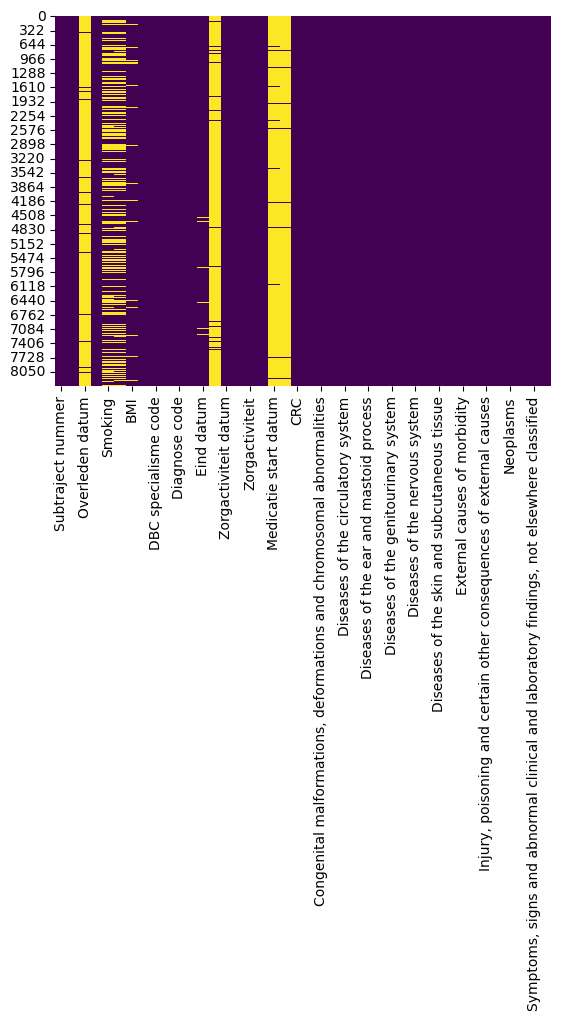

In [27]:
# Visualize missing values
sns.heatmap(df2.isnull(), cbar=False, cmap='viridis')
plt.show()

In [28]:
df2["Event"] =  0

df2.loc[df2['Overleden datum'].notna() , 'Event'] = 1
df2['Event'].value_counts()

Event
0    8064
1     306
Name: count, dtype: int64

#To calculate the time difference/survival
- date of today (if no time of death) 

In [29]:
date_today = datetime(2024,6,14)
df2["Datum_cal"] = df2['Overleden datum'].fillna(date_today)
df2["Datum_cal"].isnull().sum()

0

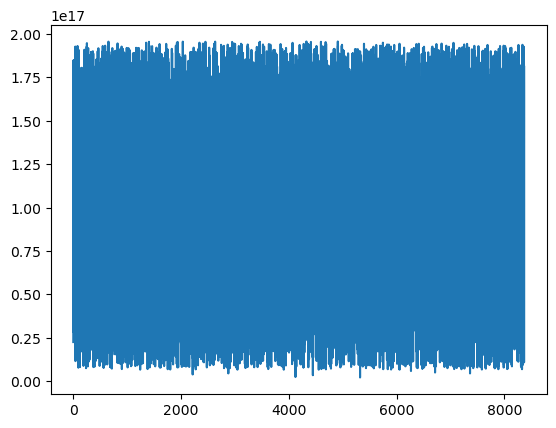

0        8.700000
1       31.133333
2       27.633333
3       53.200000
4       68.700000
          ...    
8365    70.800000
8366    63.000000
8367     4.200000
8368    48.333333
8369    69.833333
Name: Survival in months, Length: 8370, dtype: float64

In [30]:
df2["Survival in months"] = df2["Datum_cal"] - df2["Start datum"]
df2["Survival in months"].plot()
plt.show()
df2["Survival in months"] = df2["Survival in months"] / pd.Timedelta(days=30)
df2["Survival in months"] 

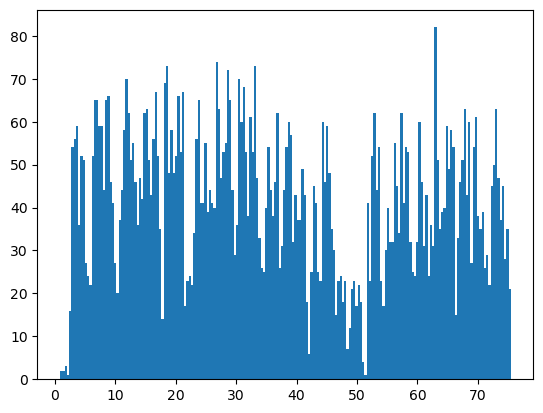

In [31]:
T = df2["Survival in months"]
E = df2["Event"]
plt.hist(T, bins = 200)
plt.show()

df2 = df2[["Patiënt leeftijd", "Roken", "Alcoholgebruik", "BMI", 'Medicatie', 'Time','Target']]


scaler = preprocessing.StandardScaler()
df2[['Patiënt leeftijd',"BMI"]] = scaler.fit_transform(df2[['Patiënt leeftijd',"BMI"]])


<Axes: >

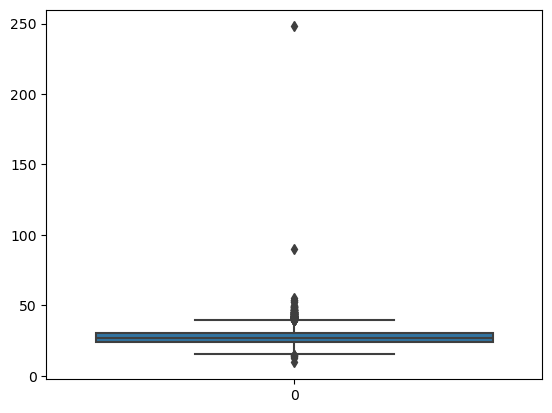

In [32]:

sns.boxplot(df2['BMI'])

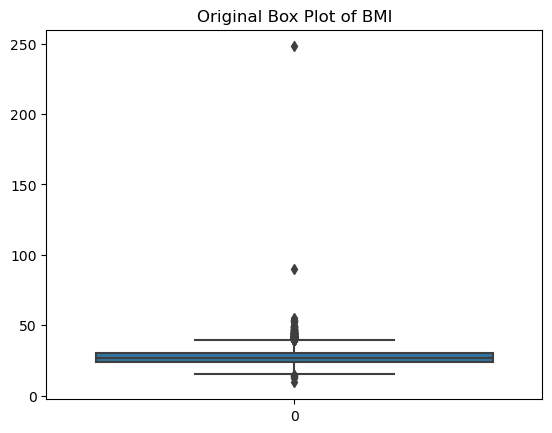

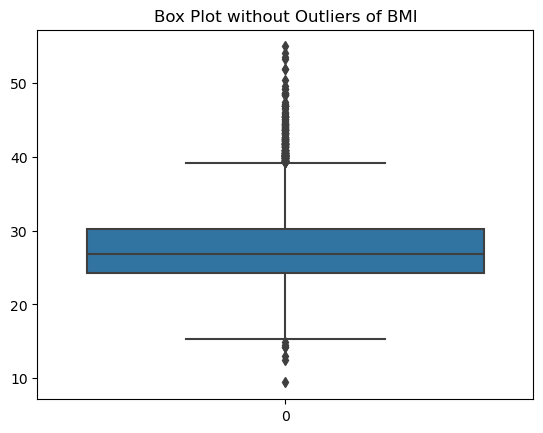

In [33]:
def removal_box_plot(df, column, threshold):
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()
 
    removed_outliers = df[df[column] <= threshold]
 
    sns.boxplot(removed_outliers[column])
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    return removed_outliers
 
 
threshold_value = 60
 
df2_min_outliers = removal_box_plot(df2, 'BMI', threshold_value)

In [34]:
np.nanpercentile(df2['BMI'], 25, method='midpoint')

24.2

In [35]:
Q1 = np.nanpercentile(df2['BMI'], 25, method='midpoint')
Q3 = np.nanpercentile(df2['BMI'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)

6.0


In [36]:
df2_min_outliers = df2[df2['BMI'] <= 80]

In [139]:

df2_compleet = df2_min_outliers[~df2_min_outliers['Smoking'].isnull() & ~df2_min_outliers['Alcohol'].isnull()]
df2_Smoking_na = df2_min_outliers[df2_min_outliers['Smoking'].isnull()]
df2_alcohol_na = df2_min_outliers[df2_min_outliers['Alcohol'].isnull()]

In [38]:
print(df2_min_outliers['Event'].value_counts(normalize=False),df2_min_outliers['Event'].value_counts(normalize=True))
df2_min_outliers.describe()

Event
0    7738
1     303
Name: count, dtype: int64 Event
0    0.962318
1    0.037682
Name: proportion, dtype: float64


,Subtraject nummer,Overleden datum,Age,BMI,DBC specialisme code,Diagnose code,Start datum,Eind datum,Vorige zorgactiviteit datum,Zorgactiviteit datum,...,Factors influencing health status and contact with health services,"Injury, poisoning and certain other consequences of external causes","Mental, Behavioral and Neurodevelopmental disorders",Neoplasms,"Pregnancy, childbirth and the puerperium","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",Unknown classification,Event,Datum_cal,Survival in months
count,8.041000e+03,303,8041.000000,8041.000000,8041.0,8041.0,8041,7977,436,8041,...,8041.000000,8041.000000,8041.000000,8041.000000,8041.000000,8041.000000,8041.000000,8041.000000,8041,8041.000000
mean,2.556102e+07,2022-06-17 09:54:03.564356352,64.855366,27.558351,318.0,830.0,2021-04-23 08:24:49.963934720,2021-07-11 22:55:11.620910080,2021-05-09 00:56:08.807339520,2021-04-25 11:54:00.044770560,...,0.964930,0.130456,0.031215,0.125358,0.011814,0.969656,0.201716,0.037682,2024-05-17 13:59:42.987190528,37.341085
min,1.316319e+07,2018-06-13 00:00:00,52.000000,9.400000,318.0,830.0,2018-04-03 00:00:00,2018-06-06 00:00:00,2018-04-12 00:00:00,2018-04-03 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018-06-13 00:00:00,0.833333
25%,2.242390e+07,2021-07-10 12:00:00,59.000000,24.200000,318.0,830.0,2019-08-30 00:00:00,2019-11-24 00:00:00,2019-09-21 18:00:00,2019-09-04 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,18.666667
50%,2.521321e+07,2022-10-07 00:00:00,65.000000,26.900000,318.0,830.0,2021-06-23 00:00:00,2021-09-11 00:00:00,2021-07-11 12:00:00,2021-06-24 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,35.000000
75%,2.861956e+07,2023-10-03 00:00:00,71.000000,30.200000,318.0,830.0,2022-11-15 00:00:00,2023-01-30 00:00:00,2022-12-17 06:00:00,2022-11-16 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,57.400000
max,3.188181e+07,2024-06-14 00:00:00,78.000000,55.000000,318.0,830.0,2024-03-29 00:00:00,2024-06-10 00:00:00,2024-03-19 00:00:00,2024-03-29 00:00:00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2024-06-14 00:00:00,75.466667
std,3.553528e+06,NaN,6.405288,4.968122,0.0,0.0,NaN,NaN,NaN,NaN,...,0.183969,0.336826,0.173909,0.331144,0.108057,0.171544,0.401306,0.190438,NaN,21.467209


In [39]:
print(df2_compleet['Event'].value_counts(normalize=False),df2_compleet['Event'].value_counts(normalize=True))
df2_compleet.describe()

Event
0    4685
1     231
Name: count, dtype: int64 Event
0    0.953011
1    0.046989
Name: proportion, dtype: float64


,Subtraject nummer,Overleden datum,Age,BMI,DBC specialisme code,Diagnose code,Start datum,Eind datum,Vorige zorgactiviteit datum,Zorgactiviteit datum,...,Factors influencing health status and contact with health services,"Injury, poisoning and certain other consequences of external causes","Mental, Behavioral and Neurodevelopmental disorders",Neoplasms,"Pregnancy, childbirth and the puerperium","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",Unknown classification,Event,Datum_cal,Survival in months
count,4.916000e+03,231,4916.000000,4916.000000,4916.0,4916.0,4916,4878,321,4916,...,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916,4916.000000
mean,2.542008e+07,2022-06-15 10:29:36.623376640,65.015663,27.726648,318.0,830.0,2021-03-19 10:58:11.619202816,2021-06-06 22:07:31.660516608,2021-04-25 19:08:24.672897280,2021-03-22 06:11:25.435313152,...,0.953621,0.155614,0.037632,0.149512,0.014849,0.959317,0.241660,0.046989,2024-05-10 17:14:18.258746880,38.275373
min,1.316328e+07,2018-06-13 00:00:00,54.000000,12.400000,318.0,830.0,2018-04-04 00:00:00,2018-06-06 00:00:00,2018-05-07 00:00:00,2018-04-05 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018-06-13 00:00:00,0.833333
25%,2.196202e+07,2021-07-25 00:00:00,59.000000,24.300000,318.0,830.0,2019-05-24 00:00:00,2019-08-17 06:00:00,2019-09-05 00:00:00,2019-05-28 18:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,18.025000
50%,2.488480e+07,2022-10-06 00:00:00,65.000000,27.100000,318.0,830.0,2021-04-12 12:00:00,2021-07-04 12:00:00,2021-06-04 00:00:00,2021-04-13 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,36.816667
75%,2.876552e+07,2023-09-24 12:00:00,71.000000,30.500000,318.0,830.0,2022-11-29 00:00:00,2023-02-13 18:00:00,2022-12-21 00:00:00,2022-11-30 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,60.000000
max,3.184819e+07,2024-06-14 00:00:00,78.000000,55.000000,318.0,830.0,2024-03-29 00:00:00,2024-06-10 00:00:00,2024-03-19 00:00:00,2024-03-29 00:00:00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2024-06-14 00:00:00,75.433333
std,3.699512e+06,NaN,6.437015,5.119673,0.0,0.0,NaN,NaN,NaN,NaN,...,0.210326,0.362526,0.190324,0.356629,0.120963,0.197576,0.428133,0.211638,NaN,22.382226


In [40]:
print(df2_Smoking_na['Event'].value_counts(normalize=False),df2_Smoking_na['Event'].value_counts(normalize=True))
df2_Smoking_na.describe()

Event
0    2916
1      63
Name: count, dtype: int64 Event
0    0.978852
1    0.021148
Name: proportion, dtype: float64


,Subtraject nummer,Overleden datum,Age,BMI,DBC specialisme code,Diagnose code,Start datum,Eind datum,Vorige zorgactiviteit datum,Zorgactiviteit datum,...,Factors influencing health status and contact with health services,"Injury, poisoning and certain other consequences of external causes","Mental, Behavioral and Neurodevelopmental disorders",Neoplasms,"Pregnancy, childbirth and the puerperium","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",Unknown classification,Event,Datum_cal,Survival in months
count,2.979000e+03,63,2979.000000,2979.000000,2979.0,2979.0,2979,2953,111,2979,...,2979.000000,2979.000000,2979.000000,2979.000000,2979.000000,2979.000000,2979.000000,2979.000000,2979,2979.000000
mean,2.579144e+07,2022-06-09 05:20:00,64.630077,27.365257,318.0,830.0,2021-06-18 00:21:45.135951616,2021-09-05 10:58:48.073146112,2021-06-15 13:50:16.216216320,2021-06-19 03:25:26.283987456,...,0.984223,0.088285,0.020477,0.085264,0.007049,0.987244,0.133602,0.021148,2024-05-29 10:33:13.957703936,35.880821
min,1.316319e+07,2019-04-12 00:00:00,52.000000,9.400000,318.0,830.0,2018-04-03 00:00:00,2018-07-01 00:00:00,2018-04-12 00:00:00,2018-04-03 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019-04-12 00:00:00,1.933333
25%,2.293810e+07,2021-02-19 00:00:00,59.000000,24.200000,318.0,830.0,2019-12-24 00:00:00,2020-03-09 00:00:00,2019-11-06 00:00:00,2019-12-24 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,19.316667
50%,2.556257e+07,2022-10-29 00:00:00,65.000000,26.700000,318.0,830.0,2021-09-23 00:00:00,2021-12-15 00:00:00,2021-09-21 00:00:00,2021-09-23 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,32.966667
75%,2.856219e+07,2023-10-21 00:00:00,70.000000,29.900000,318.0,830.0,2022-11-02 00:00:00,2023-01-23 00:00:00,2022-12-15 00:00:00,2022-11-04 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,53.516667
max,3.188181e+07,2024-03-18 00:00:00,76.000000,48.700000,318.0,830.0,2024-03-28 00:00:00,2024-06-10 00:00:00,2024-03-14 00:00:00,2024-03-28 00:00:00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2024-06-14 00:00:00,75.466667
std,3.309332e+06,NaN,6.350686,4.708288,0.0,0.0,NaN,NaN,NaN,NaN,...,0.124633,0.283756,0.141648,0.279320,0.083678,0.112238,0.340281,0.143902,NaN,19.894296


In [41]:
print(df2_alcohol_na['Event'].value_counts(normalize=False),df2_alcohol_na['Event'].value_counts(normalize=True))
df2_alcohol_na.describe()

Event
0    2891
1      69
Name: count, dtype: int64 Event
0    0.976689
1    0.023311
Name: proportion, dtype: float64


,Subtraject nummer,Overleden datum,Age,BMI,DBC specialisme code,Diagnose code,Start datum,Eind datum,Vorige zorgactiviteit datum,Zorgactiviteit datum,...,Factors influencing health status and contact with health services,"Injury, poisoning and certain other consequences of external causes","Mental, Behavioral and Neurodevelopmental disorders",Neoplasms,"Pregnancy, childbirth and the puerperium","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",Unknown classification,Event,Datum_cal,Survival in months
count,2.960000e+03,69,2960.000000,2960.000000,2960.0,2960.0,2960,2934,111,2960,...,2960.000000,2960.000000,2960.000000,2960.000000,2960.000000,2960.000000,2960.000000,2960.000000,2960,2960.000000
mean,2.592404e+07,2022-06-20 11:07:49.565217280,64.622635,27.264561,318.0,830.0,2021-07-16 06:07:47.027026688,2021-10-03 20:45:38.650306816,2021-06-18 17:56:45.405405440,2021-07-17 08:03:34.054054144,...,0.982095,0.092905,0.020946,0.089189,0.006419,0.985473,0.137838,0.023311,2024-05-28 02:39:04.864865024,34.895169
min,1.316319e+07,2019-04-12 00:00:00,52.000000,9.400000,318.0,830.0,2018-04-03 00:00:00,2018-07-01 00:00:00,2018-04-12 00:00:00,2018-04-03 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019-04-12 00:00:00,1.933333
25%,2.314223e+07,2021-04-08 00:00:00,59.000000,24.200000,318.0,830.0,2020-02-10 00:00:00,2020-05-05 00:00:00,2019-11-06 00:00:00,2020-02-12 12:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,19.158333
50%,2.560145e+07,2022-10-29 00:00:00,65.000000,26.600000,318.0,830.0,2021-10-08 00:00:00,2021-12-28 12:00:00,2021-09-17 00:00:00,2021-10-08 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,32.333333
75%,2.857636e+07,2023-10-06 00:00:00,70.000000,29.725000,318.0,830.0,2022-11-09 00:00:00,2023-01-26 00:00:00,2022-12-29 12:00:00,2022-11-09 06:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2024-06-14 00:00:00,52.066667
max,3.188181e+07,2024-03-18 00:00:00,76.000000,48.700000,318.0,830.0,2024-03-28 00:00:00,2024-06-10 00:00:00,2024-03-14 00:00:00,2024-03-28 00:00:00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2024-06-14 00:00:00,75.466667
std,3.239761e+06,NaN,6.361464,4.709715,0.0,0.0,NaN,NaN,NaN,NaN,...,0.132630,0.290349,0.143228,0.285065,0.079874,0.119670,0.344788,0.150914,NaN,19.315994


Clean features

In [42]:
df2_min_outliers = df2_min_outliers.drop(columns=columns_drop)
df2_min_outliers = df2_min_outliers.drop(columns='Datum_cal')





In [43]:
#one df for cox_time
df2_compleet_cox = df2_compleet.drop(columns=columns_drop2)

#df for rsf
df2_compleet = df2_compleet.drop(columns=['Datum_cal'])

df2_compleet = df2_compleet.drop(columns=columns_drop)



# patient characteristics

In [135]:
df2_compleet.groupby('Event')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0,4685.0,64.831804,6.418501,54.0,59.0,65.0,71.0,76.0
1,231.0,68.744589,5.639893,54.0,65.0,71.0,73.0,78.0


In [140]:
df2_compleet.groupby('Event')['BMI'].describe()

,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0,4685.0,27.759658,5.019467,12.4,24.3,27.2,30.5,55.0
1,231.0,27.057143,6.822299,15.3,22.3,25.9,30.3,48.6


In [136]:
print(df2_compleet.groupby('Event')['Smoking'].value_counts())
print(df2_compleet.groupby('Event')['Smoking'].value_counts(normalize=True))

Event  Smoking
0      Former     2223
       No         1418
       Yes        1042
                     2
1      Former      108
       Yes          76
       No           47
Name: count, dtype: int64
Event  Smoking
0      Former     0.474493
       No         0.302668
       Yes        0.222412
                  0.000427
1      Former     0.467532
       Yes        0.329004
       No         0.203463
Name: proportion, dtype: float64


In [137]:
print(df2_compleet.groupby('Event')['Alcohol'].value_counts())
print(df2_compleet.groupby('Event')['Alcohol'].value_counts(normalize=True))

Event  Alcohol
0      Yes        3181
       No         1461
                    43
1      Yes         137
       No           92
                     2
Name: count, dtype: int64
Event  Alcohol
0      Yes        0.678975
       No         0.311846
                  0.009178
1      Yes        0.593074
       No         0.398268
                  0.008658
Name: proportion, dtype: float64


In [143]:
for column in final_dummy_df.columns:
    print(df2_compleet.groupby('Event')[column].value_counts())
    print(df2_compleet.groupby('Event')[column].value_counts(normalize=True))

Event  CRC
0      0      4677
       1         8
1      0       230
       1         1
Name: count, dtype: int64
Event  CRC
0      0      0.998292
       1      0.001708
1      0      0.995671
       1      0.004329
Name: proportion, dtype: float64
Event  Certain infectious and parasitic diseases
0      0                                            4486
       1                                             199
1      0                                             213
       1                                              18
Name: count, dtype: int64
Event  Certain infectious and parasitic diseases
0      0                                            0.957524
       1                                            0.042476
1      0                                            0.922078
       1                                            0.077922
Name: proportion, dtype: float64
Event  Congenital malformations, deformations and chromosomal abnormalities
0      0                                      

In [153]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df2_compleet['Smoking'], df2_compleet['Event']))
print(f"Chi-square statistic for : {chi2}")
print(f"P-value: {p}")

Chi-square statistic for : 18.389833618084516
P-value: 0.0003654796019836963


In [150]:


for column in final_dummy_df.columns:
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(df2_compleet[column], df2_compleet['Event']))
    print(f"Chi-square statistic for {column}: {chi2}")
    print(f"P-value: {p}")




Chi-square statistic for CRC: 0.014774410163046463
P-value: 0.9032553890107391
Chi-square statistic for Certain infectious and parasitic diseases: 5.742309525332046
P-value: 0.016561002521198954
Chi-square statistic for Congenital malformations, deformations and chromosomal abnormalities: 2.1734577569956905
P-value: 0.14041021227039083
Chi-square statistic for Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism: 5.128579573201932
P-value: 0.023534980278354576
Chi-square statistic for Diseases of the circulatory system: 35.65918903814314
P-value: 2.3503659748210407e-09
Chi-square statistic for Diseases of the digestive system: 2.394627797660833
P-value: 0.12175272508088894
Chi-square statistic for Diseases of the ear and mastoid process: 0.0
P-value: 1.0
Chi-square statistic for Diseases of the eye and adnexa: 4.0126479927362935
P-value: 0.04516017092444635
Chi-square statistic for Diseases of the genitourinary system: 7.038628203768619
P-

Mask missing values in order to impute them

le = LabelEncoder()

df2_labeled = df2_min_outliers.copy()

nan_mask = df2_min_outliers['Smoking'].isna()

df2_labeled.loc[~nan_mask, 'Smoking'] = le.fit_transform(df2_min_outliers.loc[~nan_mask, 'Smoking'])


nan_mask = df2_min_outliers['Alcohol'].isna()

df2_labeled.loc[~nan_mask, 'Alcohol'] = le.fit_transform(df2_min_outliers.loc[~nan_mask, 'Alcohol'])

nan_mask = df2_min_outliers['Medicatie'].isna()

df2_labeled.loc[~nan_mask, 'Medicatie'] = le.fit_transform(df2_min_outliers.loc[~nan_mask, 'Medicatie'])

In [44]:


le = LabelEncoder() 
df2_labeled_com = df2_compleet.copy()
df2_labeled_com['Smoking'] = df2_compleet['Smoking'].astype('category')
df2_labeled_com['Smoking'] = df2_compleet['Smoking'].astype('category').cat.codes

df2_labeled_com['Alcohol'] = df2_compleet['Alcohol'].astype('category')
df2_labeled_com['Alcohol'] = df2_compleet['Alcohol'].astype('category').cat.codes

df2_labeled_com['Medicatie'] = df2_compleet['Medicatie'].astype('category')
df2_labeled_com['Medicatie'] = df2_compleet['Medicatie'].astype('category').cat.codes


In [45]:
le = LabelEncoder() 
df2_labeled_com_cox = df2_compleet_cox.copy()
df2_labeled_com_cox['Smoking'] = df2_compleet_cox['Smoking'].astype('category')
df2_labeled_com_cox['Smoking'] = df2_compleet_cox['Smoking'].astype('category').cat.codes

df2_labeled_com_cox['Alcohol'] = df2_compleet_cox['Alcohol'].astype('category')
df2_labeled_com_cox['Alcohol'] = df2_compleet_cox['Alcohol'].astype('category').cat.codes

df2_labeled_com_cox['Medicatie'] = df2_compleet_cox['Medicatie'].astype('category')
df2_labeled_com_cox['Medicatie'] = df2_compleet_cox['Medicatie'].astype('category').cat.codes

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df2_labeled = df2_labeled.replace(r'^\s*$', np.nan, regex=True)
imp_mean = IterativeImputer(random_state=seed, max_iter=5)


df_imputed = pd.DataFrame(data= imp_mean.fit_transform(df2_labeled), columns=imp_mean.get_feature_names_out())
df_imputed.isna().sum()

# Set period for time in months
## 5y = 60
## 3y = 36
## 1y = 12

In [107]:

va_times = np.arange(12, 61, 12)
period = 60

<Axes: xlabel='timeline'>

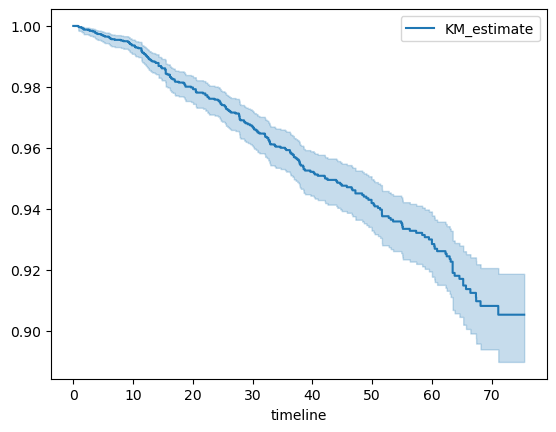

In [47]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df2_labeled_com["Survival in months"], event_observed = df2_labeled_com["Event"])

kmf.plot_survival_function()

In [48]:
from sklearn.utils import resample

minority_class = df2_labeled_com[df2_labeled_com['Event'] == 1]
majority_class = df2_labeled_com[df2_labeled_com['Event'] == 0]

# Downsample the majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=3*len(minority_class), random_state=seed)

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([minority_class, majority_downsampled])

In [49]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df2_labeled_com, duration_col = 'Survival in months', event_col= "Event")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4916 total observations, 4685 right-censored observations>
             duration col = 'Survival in months'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 4916
number of events observed = 231
   partial log-likelihood = -1689.40
         time fit was run = 2024-06-23 17:22:31 UTC

---
                                                                                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                             
Age                                                                                                   0.10      1.10      0.01            0.07            0.12                1.08                1.13
Smoking                                                                                               0.30      1.35      0.08            0.14            0.46                1.15                1.58
Alcohol                                                                                              -0.10      0.91      0.13           -0.36            0.17                0.70                1.18
BMI                                                                                                  -0.02      0.98      0.01           -0.05            0.00                0.95                1.00
Medicatie                                                                                            -0.04      0.96      0.14           -0.31            0.23                0.73                1.25
CRC                                                                                                   0.43      1.53      1.01           -1.56            2.41                0.21               11.15
Certain infectious and parasitic diseases                                                             0.51      1.67      0.26            0.01            1.02                1.01                2.76
Congenital malformations, deformations and chromosomal abnormalities                                -16.58      0.00   1559.08        -3072.32         3039.17                0.00                 inf
Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism   0.28      1.33      0.31           -0.33            0.90                0.72                2.45
Diseases of the circulatory system                                                                    0.46      1.58      0.15            0.17            0.75                1.18                2.12
Diseases of the digestive system                                                                     -0.17      0.84      0.18           -0.52            0.17                0.60                1.18
Diseases of the ear and mastoid process                                                              -0.35      0.70      0.26           -0.85            0.15                0.43                1.16
Diseases of the eye and adnexa                                                                        0.07      1.08      0.18           -0.28            0.42                0.76                1.53
Diseases of the genitourinary system                                                                  0.20      1.22      0.19           -0.17            0.57                0.84                1.76
Diseases of the musculoskeletal system and connective tissue                                          0.07      1.08      0.16           -0.23            0.38                0.79                1.46
Diseases of the nervous system                                                                       -0.05      0.95      0.18           -0.39            0.30                0.67                1.35
Diseases of the respiratory system         

<Axes: xlabel='log(HR) (95% CI)'>

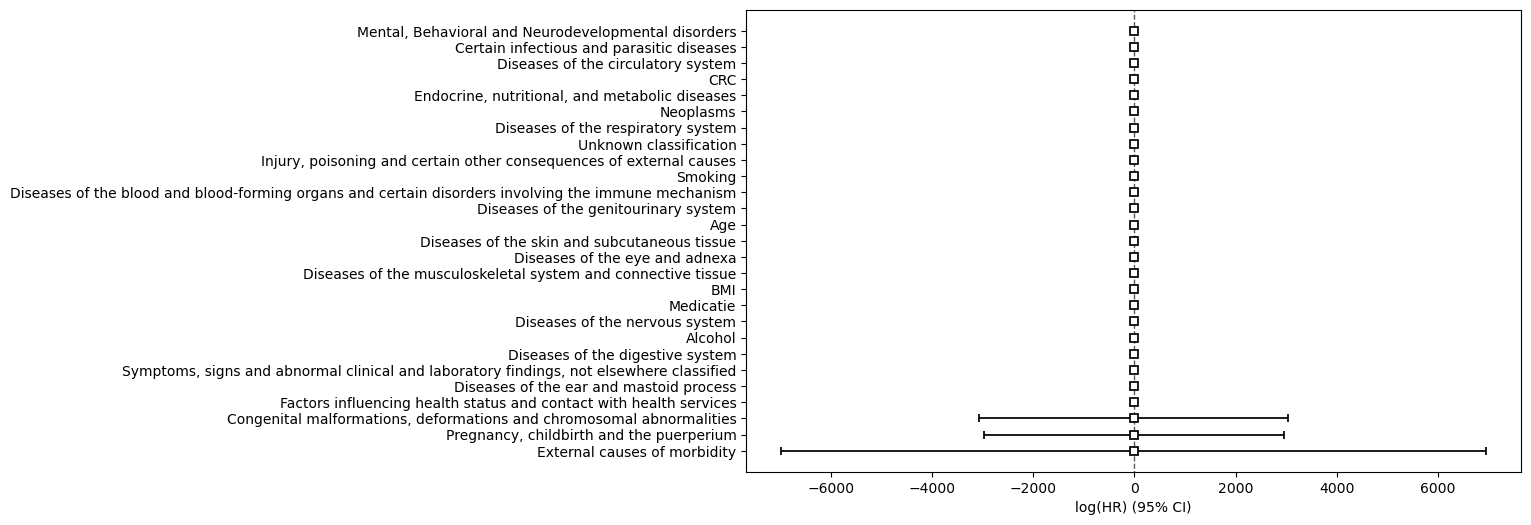

In [50]:
plt.subplots(figsize= (10,6))
cph.plot()

In [51]:
summary = cph.summary
significant_threshold = 0.05
significant_covariates = summary[summary['p'] < significant_threshold].index.tolist()
significant_covariates


['Age',
 'Smoking',
 'Certain infectious and parasitic diseases',
 'Diseases of the circulatory system',
 'Diseases of the respiratory system',
 'Endocrine, nutritional, and metabolic diseases',
 'Factors influencing health status and contact with health services',
 'Mental, Behavioral and Neurodevelopmental disorders',
 'Neoplasms',
 'Unknown classification']

<Figure size 1000x600 with 0 Axes>

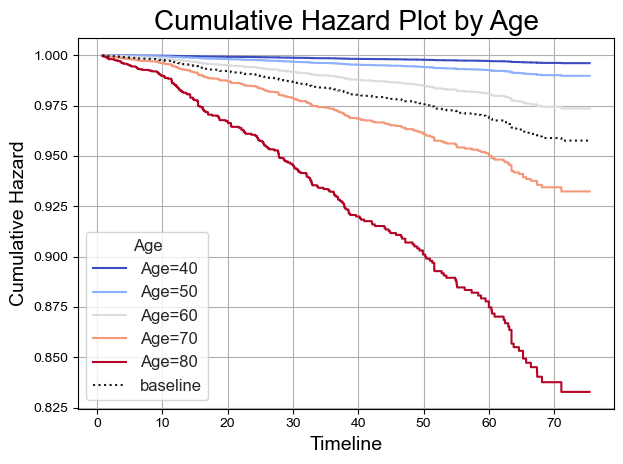

In [52]:
plt.figure(figsize=(10, 6))
ax = cph.plot_partial_effects_on_outcome('Age', [40, 50, 60, 70,80], cmap='coolwarm')

# Customize the plot
sns.set(style="whitegrid")
plt.title('Cumulative Hazard Plot by Age', fontsize=20)
plt.xlabel('Timeline', fontsize=14)
plt.ylabel('Cumulative Hazard', fontsize=14)
plt.legend(title='Age', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

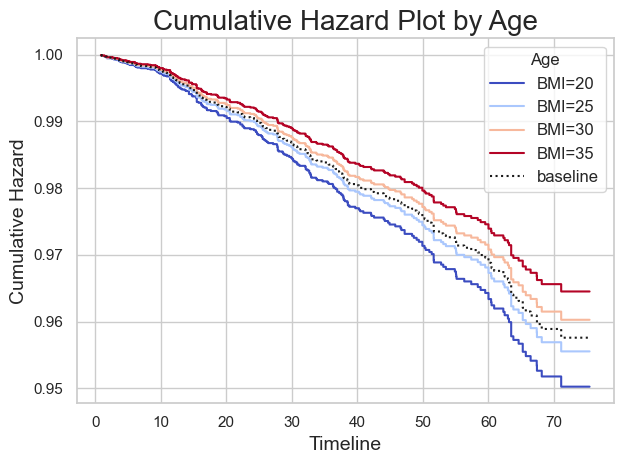

In [53]:
plt.figure(figsize=(10, 6))
ax = cph.plot_partial_effects_on_outcome('BMI', [20,25,30,35], cmap='coolwarm')

# Customize the plot
sns.set(style="whitegrid")
plt.title('Cumulative Hazard Plot by Age', fontsize=20)
plt.xlabel('Timeline', fontsize=14)
plt.ylabel('Cumulative Hazard', fontsize=14)
plt.legend(title='Age', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

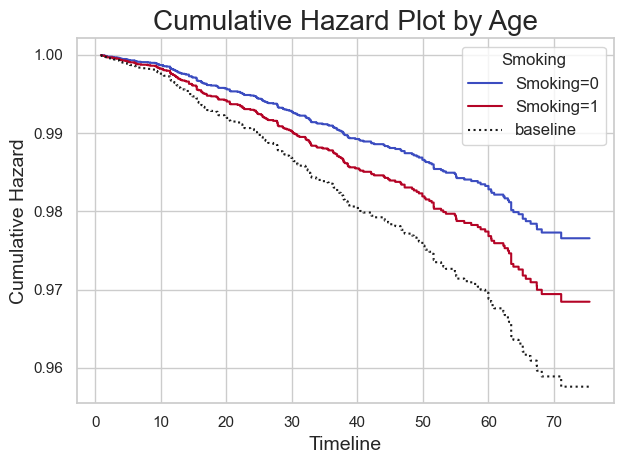

In [54]:
plt.figure(figsize=(10, 6))
ax = cph.plot_partial_effects_on_outcome('Smoking', [0,1], cmap='coolwarm')

# Customize the plot
sns.set(style="whitegrid")
plt.title('Cumulative Hazard Plot by Age', fontsize=20)
plt.xlabel('Timeline', fontsize=14)
plt.ylabel('Cumulative Hazard', fontsize=14)
plt.legend(title='Smoking', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [55]:
T = df2_compleet['Survival in months']
E = df2_compleet['Event']
X = df2_compleet.drop(['Event', 'Survival in months'], axis=1)  # Features


scaler = StandardScaler()
X[['Age', 'BMI']] = scaler.fit_transform(X[['Age', 'BMI']])

X = encode_categorical(X)


y = df2_compleet[['Event','Survival in months']].to_numpy()
aux = [(e1,e2) for e1,e2 in y]
y = np.array(aux, dtype=[('Event', 'bool'), ('Survival in months', 'float')])

#een van de twee Encode
X = encode_categorical(X)
#X = np.array(encode_categorical(X), dtype=np.float64)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y['Event'])

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Event"], y["Survival in months"], prediction)
    return result[0]


#COX PH

In [121]:
param_grid = {
    'alphas' : [10.0 ** np.linspace(-4, 4, 50)],
    "l1_ratio" : 10.0 ** np.linspace(0, 1, 50) # 0.0 means L2 penalty, 1.0 means L1 penalty
}
# Example usage with GridSearchCV
cph = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.9)
cv = StratifiedKFold(n_splits=5,random_state=None)
cph_sc = GridSearchCV(estimator=cph, param_grid=param_grid, cv=cv, scoring=score_survival_model)

cph_sc.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                              l1_ratio=0.9),
             param_grid={'alphas': [array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.2505519...
        2.55954792,  2.6826958 ,  2.8117687 ,  2.9470517 ,  3.0888436 ,
        3.23745754,  3.39322177,  3.55648031,  3.72759372,  3.90693994,
        4.09491506,  4.29193426,  4.49843267,  4.71486636,  4.94171336,
        5.17947468,  5.42867544,  5.68986603,  5.96362332,  6.25055193,
        6.55128557,  6.86648845,  7.19685673,  7.54312006,  7.90604321,
        8.28642773,  8.68511374,  9.10298178,  9.54095476, 10.        ])},
             scoring=<function score_survival_model at 0x3670cafc0>)

In [122]:
round(cph_sc.best_score_, 3), cph_sc.best_params_
cph.set_params(**cph_sc.best_params_)
cph.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-0...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                       fit_baseline_model=True, l1_ratio=1.0)

[0.05970915]
Concordance index: 0.8217
0.8376926781933829


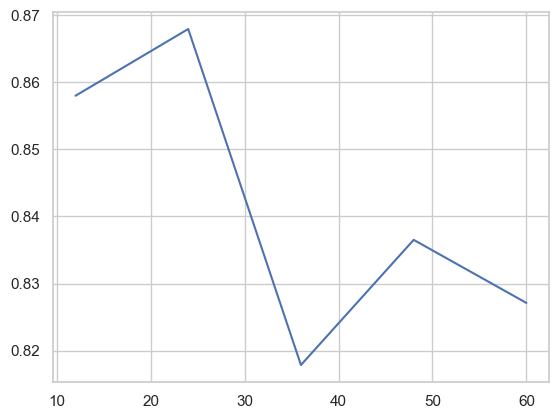

In [123]:
risk_scores= cph.predict(X_test)
survs = cph.predict_survival_function(X_test)
preds = [fn(seed) for fn in survs]

times, score = brier_score(y_train, y_test, preds, period)
print(score)
cindex = concordance_index_censored(y_test['Event'], y_test['Survival in months'],risk_scores)[0]
print(f"Concordance index: {cindex:.4f}")

#va_times = np.arange(12, 60, 12)

cph_auc, cph_mean_auc  = cumulative_dynamic_auc(y_train, y_test, risk_scores, va_times)
print(cph_mean_auc)

plt.plot(va_times,  cph_auc)

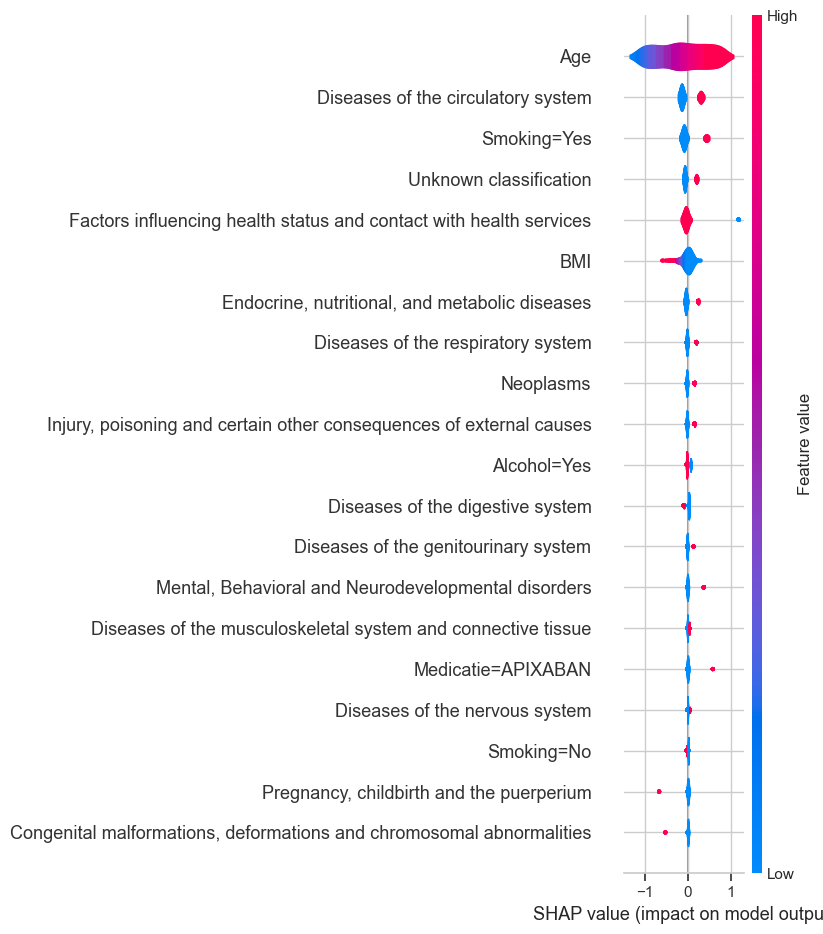

In [59]:
explainer_cph = shap.Explainer(cph.predict, X_test)
#Calculates the SHAP values - It takes some time
shap_values_cph = explainer_cph(X_test)
shap.summary_plot(shap_values_cph, plot_type='violin')

Random survival forest

T = df2_compleet['Survival in months']
E = df2_compleet['Event']
X = df2_compleet.drop(['Survival in months', 'Event'], axis=1)  # Features


scaler = StandardScaler()
X[['Age', 'BMI']] = scaler.fit_transform(X[['Age', 'BMI']])

X = encode_categorical(X)


y = df2_compleet[['Event','Survival in months']].to_numpy()
aux = [(e1,e2) for e1,e2 in y]
y = np.array(aux, dtype=[('Event', 'bool'), ('Survival in months', 'float')])

#een van de twee Encode
X = encode_categorical(X)
#X = np.array(encode_categorical(X), dtype=np.float64)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)



In [60]:
param_grid = {'n_estimators' :(10, 500),  # n_estimators
          'max_features' :(0.1, 1.0),  # max_features
         'min_samples_split' : (2, 50),     # min_samples_split
          'min_samples_leaf' :(1, 50)}   # min_samples_leaf

rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=seed
)

gcv = GridSearchCV(rsf, param_grid, scoring=score_survival_model, n_jobs=-1, cv=cv,verbose=2)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=50, n_estimators=10; total time=   0.5s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=50, n_estimators=10; total time=   0.5s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=50, n_estimators=10; total time=   0.5s
[CV] END max_features=0.1, min_samples_leaf=1, min_samples_split=50, n_estimators=10; total time=   0.3s

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomSurvivalForest(min_samples_leaf=15,
                                            min_samples_split=10,
                                            n_estimators=1000, n_jobs=-1,
                                            random_state=60),
             n_jobs=-1,
             param_grid={'max_features': (0.1, 1.0),
                         'min_samples_leaf': (1, 50),
                         'min_samples_split': (2, 50),
                         'n_estimators': (10, 500)},
             scoring=<function score_survival_model at 0x3670cafc0>, verbose=2)


def rsf_cv_score(n_estimators, max_features, min_samples_split, min_samples_leaf , random_state=seed):
    
    n_estimators = int(n_estimators)
    max_features = max(0.1, min(max_features, 1.0))  # max_features should be between 0.1 and 1.0
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    svc = RandomSurvivalForest(
        n_estimators=n_estimators, 
        max_features = max_features,
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf 
        
    )
    check = pd.DataFrame(data=y_train)
    # Perform cross-validation and return the mean score
    ci = concordance_index_censored(check["Event"], check["Survival in months"], rsf.predict(X_train))
    
    return -ci[0]

# Define the bounds for the hyperparameters
bounds = {'n_estimators' :(10, 500),  # n_estimators
          'max_features' :(0.1, 1.0),  # max_features
         'min_samples_split' : (2, 50),     # min_samples_split
          'min_samples_leaf' :(1, 50)}   # min_samples_leaf



# Initialize the Bayesian Optimizer
optimizer = BayesianOptimization(
    f=rsf_cv_score,
    pbounds=bounds,
    random_state=42,
    verbose=2
)

# Run the optimization
optimizer.maximize(init_points=10, n_iter=25)

# Print the best parameters
print("Best parameters found: ", optimizer.max)

best_params = optimizer.max['params']

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_features'] = max(0.1, min(best_params['max_features'], 1.0)) 
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

# Train the final model with the best parameters
final_model_rsf = RandomSurvivalForest(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'])

In [61]:
gcv.best_params_
rsf.set_params(**gcv.best_params_)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features=0.1, min_samples_leaf=1, min_samples_split=2,
                     n_estimators=500, n_jobs=-1, random_state=60)

In [62]:
rsf.score(X_test, y_test)


0.8298062260572023

In [63]:
X_test_sorted = X_test.sort_values(by=["BMI", "Age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,Age,Smoking=Former,Smoking=No,Smoking=Yes,Alcohol=No,Alcohol=Yes,BMI,Medicatie=APIXABAN,Medicatie=DABIGATRAN,Medicatie=RIVAROXABAN,...,Diseases of the skin and subcutaneous tissue,"Endocrine, nutritional, and metabolic diseases",External causes of morbidity,Factors influencing health status and contact with health services,"Injury, poisoning and certain other consequences of external causes","Mental, Behavioral and Neurodevelopmental disorders",Neoplasms,"Pregnancy, childbirth and the puerperium","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",Unknown classification
3650,0.619036,0.0,0.0,1.0,1.0,0.0,-2.427481,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
722,1.551240,0.0,1.0,0.0,1.0,0.0,-2.427481,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,1,1
5364,-0.002434,0.0,0.0,1.0,0.0,1.0,-2.017257,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,1,0
4556,-1.556107,0.0,0.0,1.0,1.0,0.0,4.194708,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
6818,0.619036,1.0,0.0,0.0,0.0,1.0,4.272846,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,1,1
3889,-0.313168,1.0,0.0,0.0,1.0,0.0,4.429122,0.0,0.0,1.0,...,1,0,0,1,0,0,0,0,1,1


In [64]:
pd.Series(rsf.predict(X_test_sel))

0    22.932525
1    19.892668
2     7.715797
3    16.501500
4    12.169769
5    12.497717
dtype: float64

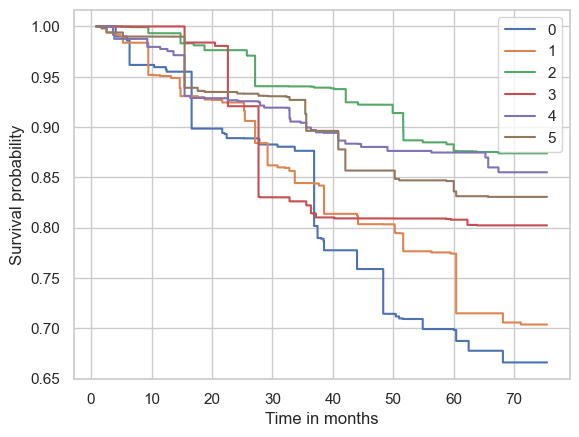

In [65]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)


In [109]:
risk_scores= rsf.predict(X_test)
survs = rsf.predict_survival_function(X_test)
preds = [fn(seed) for fn in survs]

times, score = brier_score(y_train, y_test, preds, period)
print(score)
cindex = concordance_index_censored(y_test['Event'], y_test['Survival in months'], risk_scores)[0]
print(f"Concordance index: {cindex:.4f}")

#va_times = np.arange(1, 60, 12)

cph_auc_rsf, cph_mean_auc_rsf  = cumulative_dynamic_auc(y_train, y_test, risk_scores, va_times)
print(cph_mean_auc_rsf)

[0.05656552]
Concordance index: 0.8298
0.8388453808009247


SHAP values

Permutation explainer: 985it [1:46:26,  6.50s/it]                         


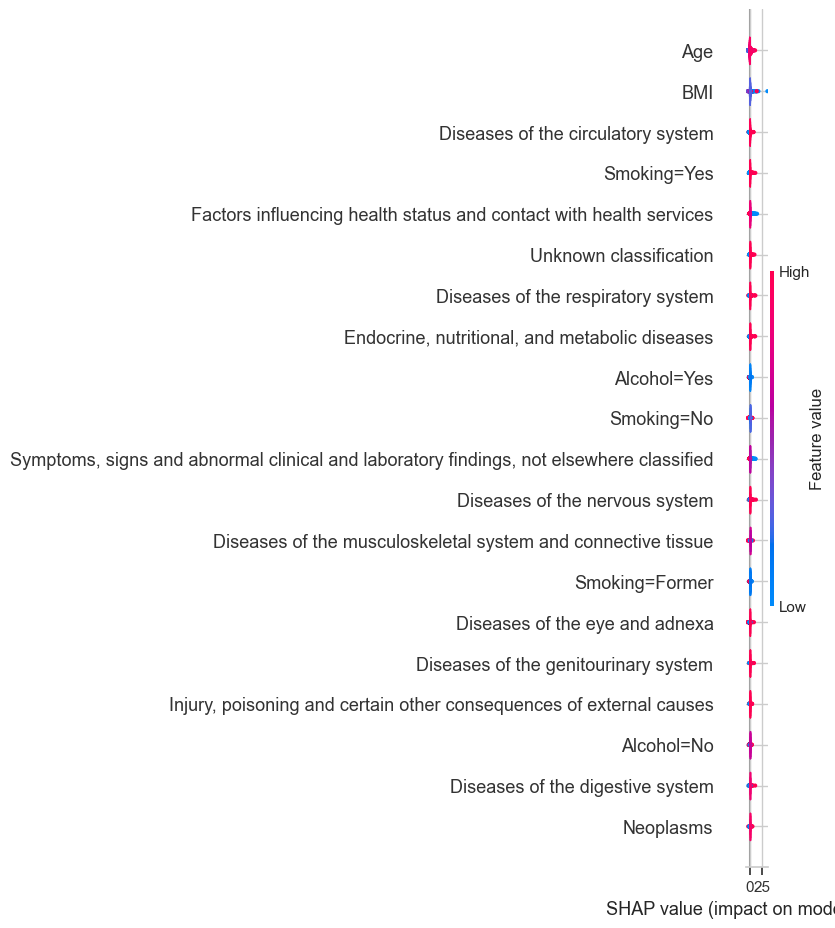

In [67]:
explainer = shap.Explainer(rsf.predict, X_test)
#Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.summary_plot(shap_values, plot_type='violin')

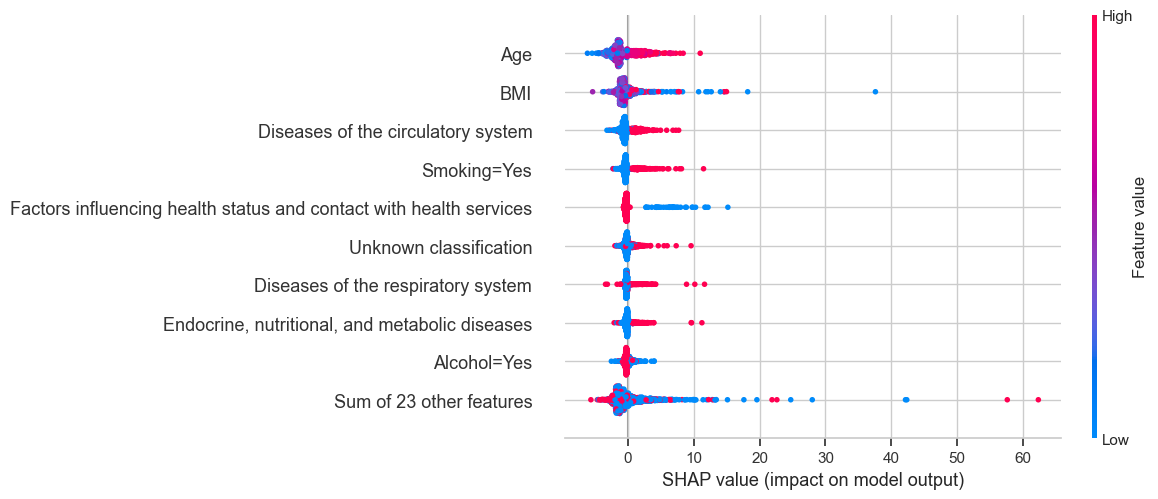

In [68]:
shap.plots.beeswarm(shap_values)

#SVM.SVC

In [69]:


set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

T = df2_compleet['Survival in months']
E = df2_compleet['Event']
X = df2_compleet.drop(['Survival in months', 'Event'], axis=1)  # Features

scaler = StandardScaler()
X[['Age', 'BMI']] = scaler.fit_transform(X[['Age', 'BMI']])

X = encode_categorical(X)

#X = np.array(encode_categorical(X), dtype=np.float64)
y = df2_compleet[['Event','Survival in months']].to_numpy()
aux = [(e1,e2) for e1,e2 in y]
y = np.array(aux, dtype=[('Event', 'bool'), ('Survival in months', 'float')])

#X_train, X_test, y_train, y_test = train_test_split(
   #X, y, test_size=0.2, random_state=seed)

categorical_cols = X.select_dtypes(include=['category', 'object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns


encode_categorical(X)


X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=seed)

In [70]:
n_censored = y.shape[0] - y["Event"].sum()
print(f"{n_censored / y.shape[0] * 100:.1f}% of records are censored")

95.3% of records are censored


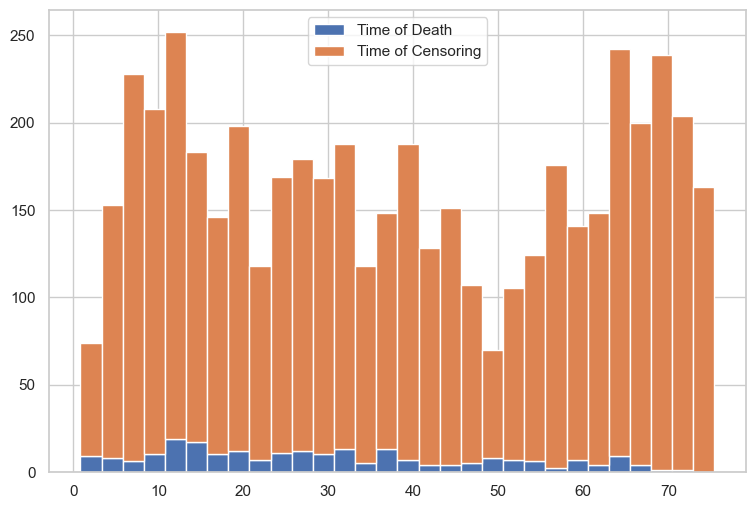

In [71]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist(
    (y["Survival in months"][y["Event"]], y["Survival in months"][~y["Event"]]), bins=30, stacked=True
)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [72]:
FSSVM = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=seed)

In [73]:
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2), 'rank_ratio': [np.random.uniform(0, 1) for _ in range(10)]}
cv = StratifiedKFold(n_splits=5)
gcv = GridSearchCV(FSSVM, param_grid, scoring=score_survival_model, n_jobs=1, cv=cv,verbose=2)


In [74]:
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(X_train, y_train)

Fitting 5 folds for each of 130 candidates, totalling 650 fits
[CV] END alpha=0.000244140625, rank_ratio=0.6174945130575702; total time=   0.9s
[CV] END alpha=0.000244140625, rank_ratio=0.6174945130575702; total time=   0.9s
[CV] END alpha=0.000244140625, rank_ratio=0.6174945130575702; total time=   1.0s
[CV] END alpha=0.000244140625, rank_ratio=0.6174945130575702; total time=   0.9s
[CV] END alpha=0.000244140625, rank_ratio=0.6174945130575702; total time=   1.1s
[CV] END alpha=0.000244140625, rank_ratio=0.9863063150440927; total time=   1.0s
[CV] END alpha=0.000244140625, rank_ratio=0.9863063150440927; total time=   1.5s
[CV] END alpha=0.000244140625, rank_ratio=0.9863063150440927; total time=   0.9s
[CV] END alpha=0.000244140625, rank_ratio=0.9863063150440927; total time=   1.0s
[CV] END alpha=0.000244140625, rank_ratio=0.9863063150440927; total time=   3.0s
[CV] END alpha=0.000244140625, rank_ratio=0.5889899264200831; total time=   1.4s
[CV] END alpha=0.000244140625, rank_ratio=0.58

In [75]:
round(gcv.best_score_, 3), gcv.best_params_

(0.335, {'alpha': 0.000244140625, 'rank_ratio': 0.015872316329233027})

In [76]:

FSSVM.set_params(**gcv.best_params_)
FSSVM.fit(X_train, y_train)

FastSurvivalSVM(alpha=0.000244140625, max_iter=1000, optimizer='avltree',
                random_state=60, rank_ratio=0.015872316329233027, tol=1e-05)

SVM does not have Brier score

In [111]:
risk_scores= FSSVM.predict(X_test)
risk_scores = -1*risk_scores
#inverse
cindex = concordance_index_censored(y_test['Event'], y_test['Survival in months'], risk_scores)[0]
print(f"Concordance index: {cindex:.4f}")



svm_auc, svm_mean_auc  = cumulative_dynamic_auc(y_train, y_test, risk_scores, va_times)
print(svm_mean_auc)

Concordance index: 0.7359
0.7255728295435007


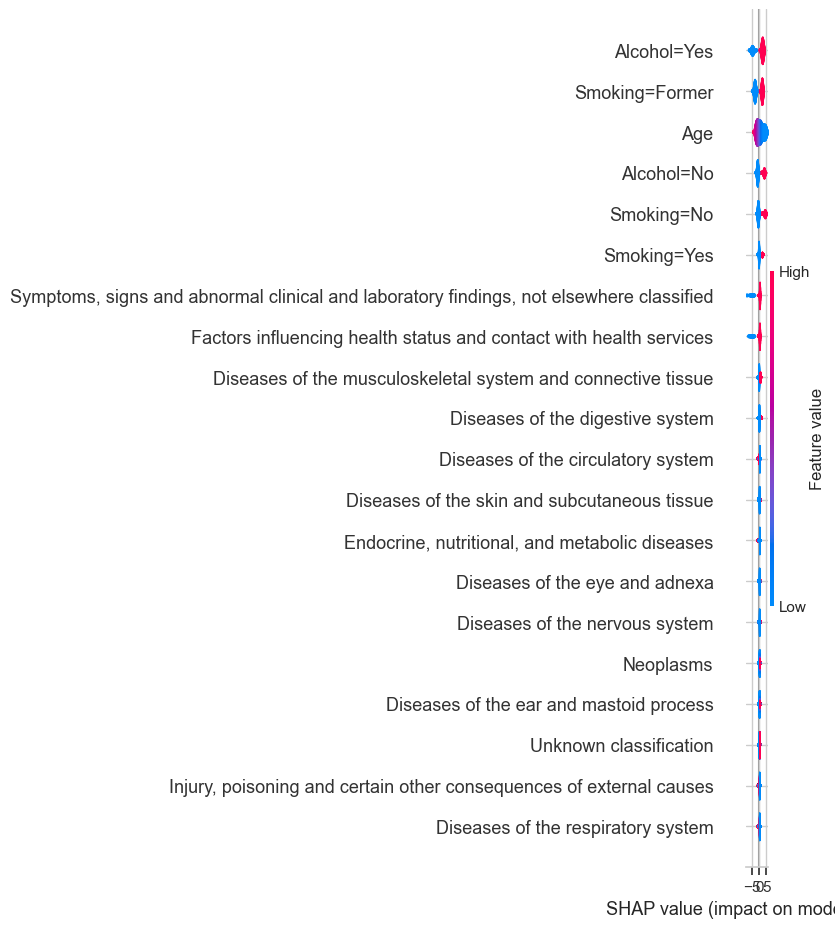

In [78]:
explainer = shap.Explainer(FSSVM.predict, X_test)
#Calculates the SHAP values - It takes some time
shap_values_FSSVM = explainer(X_test)
shap.summary_plot(shap_values_FSSVM, plot_type='violin')

In [80]:
risk_scores

array([12.98473853, 10.62545917, 11.56538673, 16.6493984 , 12.58605109,
        9.47996189, 13.76799572, 11.50235753, 12.23430869, 14.17265459,
       13.07313492,  8.69305189, 11.95018074, 14.68118004, 10.31949793,
       11.0642809 , 10.20510198,  4.07873642, 12.57673014,  8.67130215,
       15.97242351, 14.27637433, 11.07321708, 10.48406095,  7.06219136,
       11.59328809, 16.74112666, 14.87097746,  8.40843367, 14.31830475,
       15.31609117, 15.60193739, 10.73409638, 12.23785372,  9.08168003,
        8.07626362, 13.82429329, 11.00035776,  9.54959337, 14.70794792,
       15.2602144 , 11.45032007,  9.75060488, 12.07977166, 11.05993902,
        8.61201046, 10.71626451, 12.0336561 ,  7.96480191, 10.9481213 ,
       13.15404433, 10.97947351, 13.72243872, 13.40191608, 10.17717401,
        9.73344277, 12.31581476, 13.95529963,  8.58672473,  9.17907931,
       12.99269738, 10.83365977,  7.9936224 , 12.37351811, 14.26619356,
        8.44504548, 15.94379235, 13.15745593, 10.56240706, 11.54

In [81]:

print(concordance_index(y_test['Survival in months'], preds, y_test['Event']))

0.8184996466693941


XGBoost survival

In [82]:

GBS = GradientBoostingSurvivalAnalysis()
cv = StratifiedKFold(n_splits=5)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=GBS,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring=score_survival_model  # You can use a different scoring metric if needed
)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict the risk scores for the test set
risk_scores = best_model.predict(X_test)

In [117]:
risk_scores= best_model.predict(X_test)
survs = best_model.predict_survival_function(X_test)
preds = [fn(seed) for fn in survs]

times, score = brier_score(y_train, y_test, preds, period)
print(score)
cindex = concordance_index_censored(y_test['Event'], y_test['Survival in months'], risk_scores)[0]
print(f"Concordance index: {cindex:.4f}")
#va_times = np.arange(1, 60, 12)

auc_XGB, mean_auc_XGB  = cumulative_dynamic_auc(y_train, y_test, risk_scores, va_times)
print(mean_auc_XGB)

[0.0624813]
Concordance index: 0.7901
0.7839384680524282


Permutation explainer: 985it [00:15, 22.06it/s]                         


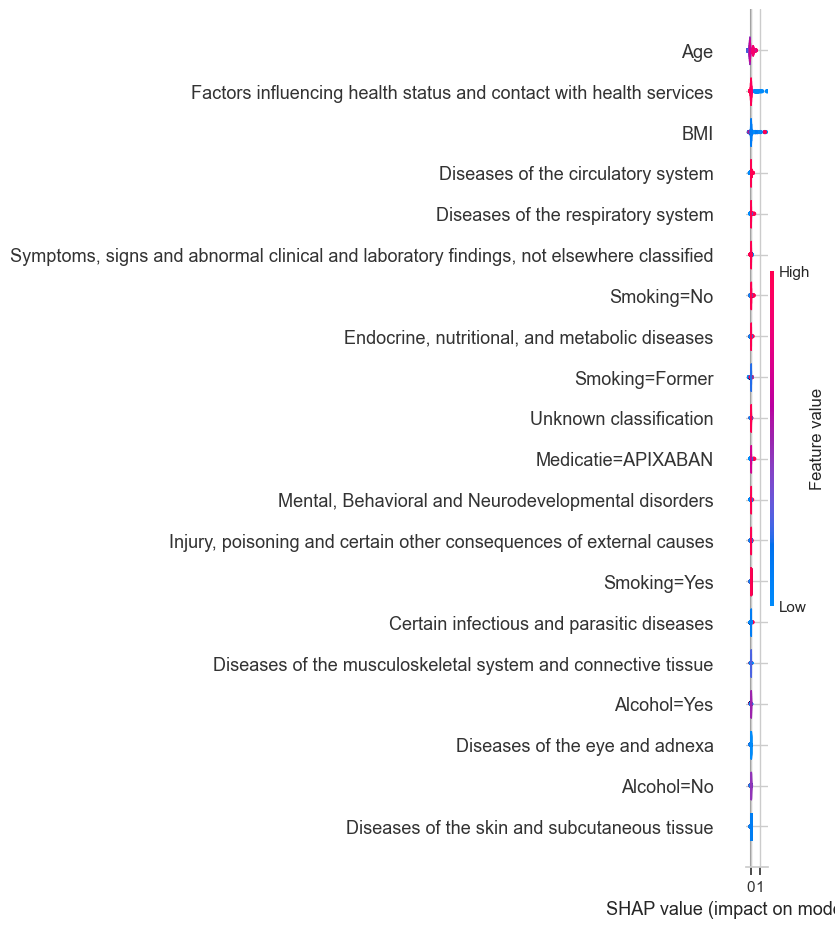

In [84]:
explainer = shap.Explainer(best_model.predict, X_test)
#Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.summary_plot(shap_values, plot_type='violin')

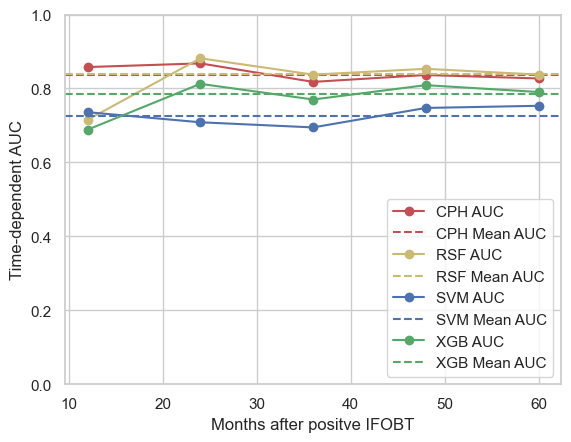

In [131]:
plt.subplot()

#CPH
plt.plot(va_times, cph_auc, marker="o", color='r', label='CPH AUC')
plt.axhline(cph_mean_auc, linestyle="--", color='r', label='CPH Mean AUC')

#RSF
plt.plot(va_times, cph_auc_rsf, marker="o", color='y', label='RSF AUC')
plt.axhline(cph_mean_auc_rsf, linestyle="--", color='y', label='RSF Mean AUC')

# SVM
plt.plot(va_times, svm_auc, marker="o", color='b', label='SVM AUC')
plt.axhline(svm_mean_auc, linestyle="--", color='b', label='SVM Mean AUC')



#XGB
plt.plot(va_times, auc_XGB, marker="o", color='g', label='XGB AUC')
plt.axhline(mean_auc_XGB, linestyle="--", color='g', label='XGB Mean AUC')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.xlabel("Months after positve IFOBT")
plt.ylabel("Time-dependent AUC")

plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()